In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np

In [81]:
actor_vial_df = pd.read_csv("data/actor_vial.csv")
vehiculos_df = pd.read_csv("data/vehiculos.csv")
siniestros_df = pd.read_csv("data/siniestros.csv")
hipothesis_df = pd.read_csv("data/hipothesis.csv")

In [289]:
vehiculos_df.drop("CLASE",axis=1)

,CODIGO_ACCIDENTE,FECHA,VEHICULO,SERVICIO,MODALIDAD,ENFUGA
0,4401423,01/01/2015,4401423-1,2.0,5.0,N
1,4401423,01/01/2015,4401423-2,3.0,NaN,N
2,4401420,01/01/2015,4401420-1,2.0,5.0,N
3,4401420,01/01/2015,4401420-2,3.0,NaN,N
4,4401429,01/01/2015,4401429-1,2.0,4.0,N
...,...,...,...,...,...,...
371600,10530494,31/12/2020,10530494-1,2.0,11.0,N
371601,10530494,31/12/2020,10530494-2,3.0,NaN,N
371602,10530493,31/12/2020,10530493-1,3.0,NaN,N
371603,10530493,31/12/2020,10530493-2,3.0,NaN,N


In [124]:

def merge_dfs(df,df2,common_keys = ['CODIGO_ACCIDENTE','FECHA']):
#     common_keys = ['CODIGO_ACCIDENTE','FECHA']
    merged_inner = pd.merge(left=df, right=df2, left_on=common_keys, right_on=common_keys,how='left')
    return merged_inner

siniestros_df["datetime"] = pd.to_datetime(siniestros_df["FECHA"].str.cat(siniestros_df["HORA"], sep=" "), format="mixed")


In [363]:
merged = merge_dfs(actor_vial_df,siniestros_df.drop("CLASE",axis=1))
merged = merge_dfs(vehiculos_df,merged)
merged['EDAD'] = merged['EDAD'].replace(to_replace='SIN INFORMACION', value='-1')
merged['EDAD'] = merged['EDAD'].astype('int')

In [364]:
# replace all NaN with 0
merged = merged.fillna(value=0)
merged.head()

,CODIGO_ACCIDENTE,FECHA,VEHICULO_x,CLASE,SERVICIO,MODALIDAD,ENFUGA,CODIGO_ACCIDENTADO,CONDICION,ESTADO,...,SEXO,VEHICULO_y,HORA,GRAVEDAD,CHOQUE,OBJETO_FIJO,DIRECCION,CODIGO_LOCALIDAD,DISENO_LUGAR,datetime
0,4401423,01/01/2015,4401423-1,1.0,2.0,5.0,N,2452500,CONDUCTOR,HERIDO,...,MASCULINO,4401423-1,09:45:00,2,1.0,0.0,CL 66A-KR 76 02,10,2,2015-01-01 09:45:00
1,4401423,01/01/2015,4401423-1,1.0,2.0,5.0,N,2452501,CONDUCTOR,ILESO,...,SIN INFORMACION,4401423-2,09:45:00,2,1.0,0.0,CL 66A-KR 76 02,10,2,2015-01-01 09:45:00
2,4401423,01/01/2015,4401423-1,1.0,2.0,5.0,N,2452508,PEATON,HERIDO,...,FEMENINO,0,09:45:00,2,1.0,0.0,CL 66A-KR 76 02,10,2,2015-01-01 09:45:00
3,4401423,01/01/2015,4401423-2,1.0,3.0,0.0,N,2452500,CONDUCTOR,HERIDO,...,MASCULINO,4401423-1,09:45:00,2,1.0,0.0,CL 66A-KR 76 02,10,2,2015-01-01 09:45:00
4,4401423,01/01/2015,4401423-2,1.0,3.0,0.0,N,2452501,CONDUCTOR,ILESO,...,SIN INFORMACION,4401423-2,09:45:00,2,1.0,0.0,CL 66A-KR 76 02,10,2,2015-01-01 09:45:00


In [365]:
def get_week_of_year(df):
    return pd.to_datetime(df["FECHA"], format="mixed")

def get_hour(data):
    return data.split(":")[0]

def get_addr(data):
     return " ".join(data.split()[:-1])

# me['HORA'] = siniestros_2019['HORA'].apply(clean_hora)

In [448]:
cond_dict = {
    'CONDUCTOR': 1,
    'MOTOCICLISTA': 2,
    'PASAJERO/ACOMPAÑANTE': 3,
    'PEATON': 4,
    'CICLISTA': 5,
    '0': 0
}
est_dict = {
    'ILESO' : 0,
    'HERIDO' : 1,
    'MUERTO': 2
}
sex_dict = {
    'MASCULINO': 0,
    'FEMENINO' : 1,
    "SIN INFORMACION": 0
}


training_data  = pd.DataFrame()


training_data["method_of_transport"] = merged.CONDICION.replace(cond_dict)
training_data["target"] = merged.ESTADO.replace(est_dict)
training_data["severity_of_crash"] = merged.GRAVEDAD.astype(int)
training_data["age"] = merged.EDAD.astype(int)
training_data["car_class"] = merged.CLASE.astype(int)
training_data["time"] = merged.HORA.apply(get_hour)
training_data["sex"] = merged.SEXO.replace(sex_dict)
training_data["crash"] =merged.CHOQUE.astype(int)


training_data["car_type"]= merged.MODALIDAD.astype(int)
training_data["area_code"] = merged.DISENO_LUGAR.astype(int)
training_data["accident_location"] = merged.DISENO_LUGAR.astype(int)
training_data["top_address"] = merged.DIRECCION.apply(get_addr)



'''
top_address           
accident_location      
area_code              
car_type              
crash                  
sex                    
time                   
car_class              
age                    
severity_of_crash      
method_of_transport    '''


top_100_locations = training_data["top_address"].value_counts()
top_100_locations= top_100_locations.keys().tolist()[0:200]
training_data.top_address = (training_data.top_address.isin(top_100_locations)).astype(int)

In [449]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import warnings
from sklearn import metrics

warnings.filterwarnings("ignore")
df = training_data.copy()
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
forest = RandomForestClassifier(n_jobs=5,verbose=1)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

# Assuming y_pred are your predicted labels
accuracy = metrics.accuracy_score(y_test, y_pred)

print(f" Accuracy: {accuracy}")

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s


 Accuracy: 0.9630101271017659


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished


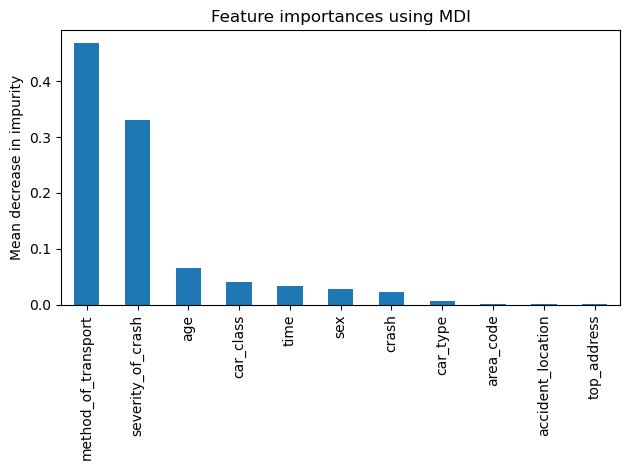

In [452]:
import matplotlib.pyplot as plt
# This code comes directly from ... 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html 
importances = forest.feature_importances_

forest_importances = pd.Series(importances, index= X_test.keys())
fig, ax = plt.subplots()
forest_importances.plot.bar()

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [444]:
forest_importances.sort_values()

top_address            0.001855
accident_location      0.002058
area_code              0.002166
car_type               0.005922
crash                  0.023185
sex                    0.030002
time                   0.033466
car_class              0.043656
age                    0.065254
severity_of_crash      0.294815
method_of_transport    0.497620
dtype: float64

In [398]:
forest

RandomForestClassifier(n_jobs=5, verbose=1)

In [410]:
y_pred.argmax()

536

In [418]:
y_train.value_counts(normalize=1)

target
0    0.801193
1    0.193195
2    0.005613
Name: proportion, dtype: float64

In [419]:
merged.ESTADO.value_counts(normalize=1)

ESTADO
ILESO     0.800776
HERIDO    0.193649
MUERTO    0.005574
Name: proportion, dtype: float64

In [420]:
siniestros_df

,CODIGO_ACCIDENTE,FECHA,HORA,GRAVEDAD,CLASE,CHOQUE,OBJETO_FIJO,DIRECCION,CODIGO_LOCALIDAD,DISENO_LUGAR,datetime
0,4401438,01/01/2015,01:05:00,2,2,NaN,NaN,KR 64A-CL 2C 02,16,2,2015-01-01 01:05:00
1,4401449,01/01/2015,05:50:00,2,3,NaN,NaN,AV AVENIDA DEL SUR-KR 65A 41,7,1,2015-01-01 05:50:00
2,4401430,01/01/2015,07:15:00,2,3,NaN,NaN,KR 19D-CL 62 S 02,19,1,2015-01-01 07:15:00
3,4401453,01/01/2015,09:30:00,3,1,1.0,NaN,KR 79-CL 42F S 71,8,1,2015-01-01 09:30:00
4,4401423,01/01/2015,09:45:00,2,1,1.0,NaN,CL 66A-KR 76 02,10,2,2015-01-01 09:45:00
...,...,...,...,...,...,...,...,...,...,...,...
196147,10530481,31/12/2020,21:20:00,3,1,1.0,NaN,CL 42-KR 86 S 02,8,1,2020-12-31 21:20:00
196148,10530439,31/12/2020,21:30:00,2,1,1.0,NaN,KR 111-CL 171 02,11,2,2020-12-31 21:30:00
196149,10530491,31/12/2020,21:34:00,3,1,1.0,NaN,CL 134-KR 5 08,1,1,2020-12-31 21:34:00
196150,10531380,31/12/2020,21:40:00,2,1,1.0,NaN,CL 142 - KR 146 02,11,1,2020-12-31 21:40:00
